# Seq2Seq model for each frequency

In [1]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

## Load Data

In [2]:
path = r'TF_HLC'

In [3]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_200.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_200.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_200.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(1000, 200) (1000, 29) (200,)


In [4]:
def text_plot(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    vs_bedrock = Vs[-1]
    return f"Vs soil: {vs_soil:.0f} m/s\nVs bedrock: {vs_bedrock:.0f} m/s\nh soil: {h_soil} m\nfreq_calc: {vs_soil/(4*(h_soil+5)):.2f} Hz"

def freq_calc(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    return vs_soil/(4*(h_soil+5))


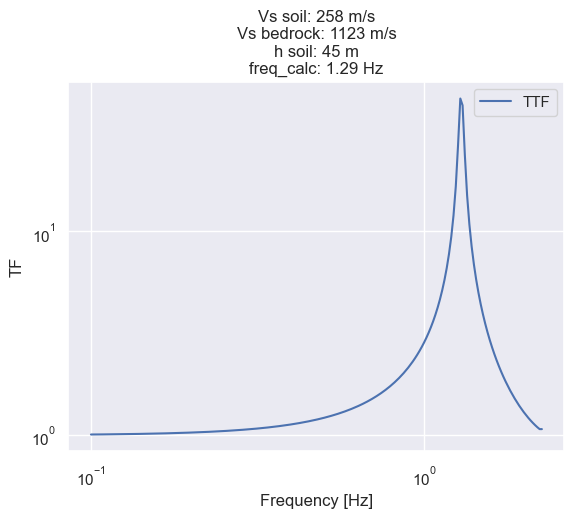

In [5]:
idx = np.random.randint(0,1000)
plt.loglog(freq_data, TTF_data[idx], label="TTF")
plt.title(text_plot(Vs_data[idx]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("TF")
plt.legend()
plt.show()

## Create Dataset and DataLoader

In [13]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):
        # Target data
        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        # Input data
        input_data = np.nan_to_num(self.Vs_values[idx], nan=0.0, posinf=0.0, neginf=0.0)
        input_data = torch.tensor(input_data, dtype=torch.float32).repeat(target_data.shape[0], 1)

        return input_data, target_data

In [14]:
dataset = TTF_dataset(TTF_data, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)
dataset[0][0]

Sizes in the dataset:  1000
Data shapes for input and target:  torch.Size([200, 29]) torch.Size([200])


tensor([[135.5332, 135.5332, 135.5332,  ...,   0.0000,   0.0000,   0.0000],
        [135.5332, 135.5332, 135.5332,  ...,   0.0000,   0.0000,   0.0000],
        [135.5332, 135.5332, 135.5332,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [135.5332, 135.5332, 135.5332,  ...,   0.0000,   0.0000,   0.0000],
        [135.5332, 135.5332, 135.5332,  ...,   0.0000,   0.0000,   0.0000],
        [135.5332, 135.5332, 135.5332,  ...,   0.0000,   0.0000,   0.0000]])

In [15]:
# Separate into training and testing
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))
print("Training shapes: ", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

Train, validation and test sizes:  700 150 150
Number of batches:  14 3 3
Training shapes:  torch.Size([50, 200, 29]) torch.Size([50, 200])


## Create Model

### LSTM

In [16]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

In [17]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional_encoder=False):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional_encoder = bidirectional_encoder
        self.num_directions = 2 if bidirectional_encoder else 1
        self.lstm = nn.LSTM(input_size, hidden_size * self.num_directions, num_layers, batch_first=True)

    def forward(self, x, hidden):
        if self.bidirectional_encoder:
            # Concatenate the hidden states from both directions
            h0, c0 = hidden
            h0 = h0.view(self.num_layers, self.num_directions, -1, self.hidden_size)
            c0 = c0.view(self.num_layers, self.num_directions, -1, self.hidden_size)
            h0 = torch.cat((h0[:, 0, :, :], h0[:, 1, :, :]), dim=2)
            c0 = torch.cat((c0[:, 0, :, :], c0[:, 1, :, :]), dim=2)
            h0 = h0.view(self.num_layers, -1, self.hidden_size * 2)
            c0 = c0.view(self.num_layers, -1, self.hidden_size * 2)
            hidden = (h0, c0)
        out, hidden = self.lstm(x, hidden)
        return out, hidden


In [18]:
# Example usage
input_size = 29
hidden_size = 10
num_layers = 5
bidirectional_encoder = False

# Example
X = torch.randn(50, 200, input_size)
encoder = EncoderLSTM(input_size, hidden_size, num_layers, bidirectional_encoder)
decoder = DecoderLSTM(hidden_size * 2 if bidirectional_encoder else hidden_size, hidden_size, num_layers, bidirectional_encoder)
mlp = nn.Linear(hidden_size * 2 if bidirectional_encoder else hidden_size, 1)

# Encode the input sequence
encoder_output, (h1, c1) = encoder(X)
print("Encoder output shape:", encoder_output.shape)
print("Encoder hidden state shape:", h1.shape)
print("Encoder cell state shape:", c1.shape)


Encoder output shape: torch.Size([50, 200, 10])
Encoder hidden state shape: torch.Size([5, 50, 10])
Encoder cell state shape: torch.Size([5, 50, 10])


In [20]:

# Use a tensor of zeros as the initial input for the decoder
#decoder_input = torch.zeros(50, 1, hidden_size * 2 if bidirectional_encoder else hidden_size).to(X.device)

# Use the last hidden state of the encoder as the initial hidden state of the decoder
decoder_input = encoder_output[:, -1].unsqueeze(1)

decoder_outputs = []
decoder_hidden = (h1, c1)
for t in range(X.shape[1]):  # Assuming the output sequence length is 1000
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_outputs.append(mlp(decoder_output))
    decoder_input = decoder_output  # Use the current output as the next input

decoder_outputs = torch.cat(decoder_outputs, dim=1).squeeze(-1)
print("Output shape after MLP:", decoder_outputs.shape)

loss = nn.L1Loss()(decoder_outputs, X[:, :, 0])
print("Loss:", loss.item())

Output shape after MLP: torch.Size([50, 200])
Loss: 0.8009837865829468


In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, device="cpu"):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.mlp = mlp.to(device)

    def forward(self, X, print_shapes=False):
        target_length = X.shape[1]

        # Encode the input sequence
        encoder_output, (h1, c1) = self.encoder(X)
        if print_shapes:
            print("Encoder output shape:", encoder_output.shape)
            print("Encoder hidden state shape:", h1.shape)
            print("Encoder cell state shape:", c1.shape)

        # Use the last hidden state of the encoder as the initial input for the decoder
        decoder_input = encoder_output[:, -1].unsqueeze(1)
        decoder_outputs = []
        decoder_hidden = (h1, c1)
        for t in range(target_length):  # Use the target length from X.shape[1]
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(self.mlp(decoder_output))
            decoder_input = decoder_output  # Use the current output as the next input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        if print_shapes:
            print("Output shape after MLP:", decoder_outputs.shape)
        return decoder_outputs.squeeze(-1)


In [27]:
# Example usage
# Assuming input_size, hidden_size, num_layers are defined
input_size = 29
hidden_size = 20
num_layers = 1
bidirectional_encoder = True

encoder = EncoderLSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional_encoder)
decoder = DecoderLSTM(hidden_size * 2 if bidirectional_encoder else hidden_size, hidden_size, num_layers, bidirectional_encoder=bidirectional_encoder)
mlp = nn.Linear(hidden_size * 2 if bidirectional_encoder else hidden_size, 1)

model = Seq2Seq(encoder, decoder, mlp, device="cpu")

# Assuming X is the input tensor
X = torch.randn(50, 200, input_size)
output = model(X, print_shapes=True)

Encoder output shape: torch.Size([50, 200, 40])
Encoder hidden state shape: torch.Size([2, 50, 20])
Encoder cell state shape: torch.Size([2, 50, 20])
Output shape after MLP: torch.Size([50, 200, 1])


In [37]:
from torch.amp import autocast, GradScaler

class Seq2SeqTeacher(nn.Module):
    def __init__(self, encoder, decoder, mlp, device="cpu"):
        super(Seq2SeqTeacher, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.mlp = mlp.to(device)

    def forward(self, X, target=None, teacher_forcing_ratio=0.5, print_shapes=False):
        device = X.device
        target_length = X.shape[1]

        # Encode the input sequence
        encoder_output, (h1, c1) = self.encoder(X)
        if print_shapes:
            print("Encoder output shape:", encoder_output.shape)
            print("Encoder hidden state shape:", h1.shape)
            print("Encoder cell state shape:", c1.shape)

        # Use the last hidden state of the encoder as the initial input for the decoder
        decoder_input = encoder_output[:, -1].unsqueeze(1).to(device)
        if print_shapes:
            print("Decoder input shape:", decoder_input.shape)

        decoder_outputs = []
        decoder_hidden = (h1, c1)
        for t in range(target_length):  # Use the target length from X.shape[1]
            with autocast('cuda'):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                if print_shapes:
                    print("Decoder output shape:", decoder_output.shape)
                    
                output = self.mlp(decoder_output)
                if print_shapes:
                    print("Output shape after MLP:", output.shape)
                decoder_outputs.append(output)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        if print_shapes:
            print("Output shape after MLP:", decoder_outputs.shape)
        return decoder_outputs.squeeze(-1)


In [38]:
# Example usage
input_size = 29
hidden_size = 2
num_layers = 2
bidirectional_encoder = True

encoder = EncoderLSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional_encoder)
decoder = DecoderLSTM(hidden_size * 2 if bidirectional_encoder else hidden_size, hidden_size, num_layers, bidirectional_encoder=bidirectional_encoder)
mlp = nn.Linear(hidden_size * 2 if bidirectional_encoder else hidden_size, 1)

model = Seq2SeqTeacher(encoder, decoder, mlp, device="cuda")

# Assuming X is the input tensor
X = torch.randn(50, 200, input_size).to("cuda")

# Assuming target is the target tensor
target = torch.randn(50, 200, 1).to("cuda")
output = model(X, target=target, print_shapes=False)
print("Output shape:", output.shape)

Output shape: torch.Size([50, 200])


## Training

In [39]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [40]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, normalize=False):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            if normalize:
                y_pred = denormalization(y_pred)
                y = denormalization(y)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                if normalize:
                    y_pred = denormalization(y_pred)
                    y = denormalization(y)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", normalize=False):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        if normalize:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [41]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.7, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

# Join L1Loss and cosine similarity
def custom_loss(y_true, y_pred, alpha=0.5):
    l1_loss = loss_fn(y_true, y_pred)
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(y_true, y_pred).mean()
    return alpha * l1_loss + (1 - alpha) * cosine_loss

Device:  cuda


In [42]:
import yaml

# Update config file
config_file = 'config/default.yaml'

# Update config file

In [43]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=1500, clipping=True, print_epoch=1000)

Training:   0%|          | 1/20000 [00:14<80:17:29, 14.45s/epoch]

Epoch 0, Train Loss: 2.8377677372523715, Val Loss: 2.790436029434204, LR: 0.0005


Training:   0%|          | 10/20000 [02:22<79:12:36, 14.26s/epoch]


KeyboardInterrupt: 

## Evaluation

In [181]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device, normalize=False)
print("Test loss: ", test_loss)

Test loss:  1.5209883848826091


In [196]:
def extract_Vs(Vs):
    # Eliminate the zeros at the end of the array
    Vs = Vs[Vs != 0]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1]) * 5
    vs_bedrock = Vs[-1]
    return vs_soil, vs_bedrock, h_soil

In [228]:
[extract_Vs(Vs) for Vs in X[:,0].cpu().numpy()]

[(230.8982, 914.52264, 105),
 (151.56673, 1040.1638, 140),
 (250.56717, 1376.8184, 100),
 (266.0034, 1290.1027, 120),
 (171.16525, 1058.634, 75),
 (124.63375, 1097.024, 75),
 (165.78442, 898.049, 115),
 (139.77481, 1473.1068, 35),
 (191.8039, 1434.5164, 20),
 (318.16333, 872.3442, 115),
 (174.46834, 1487.0681, 115),
 (154.49231, 899.4702, 45),
 (132.37524, 1292.3926, 125),
 (151.27206, 1451.4775, 60),
 (219.9033, 1443.1434, 10),
 (192.68166, 1185.7263, 120),
 (218.27563, 906.97595, 30),
 (238.50536, 1049.568, 10),
 (164.76047, 767.75397, 50),
 (226.72871, 938.8305, 85),
 (246.43243, 1464.1779, 85),
 (236.94894, 910.6289, 25),
 (213.08205, 772.8248, 135),
 (200.69319, 1243.8822, 125),
 (216.90562, 1272.5663, 5),
 (235.6906, 1479.526, 40),
 (207.52399, 834.6931, 85),
 (196.31833, 1252.4601, 10),
 (161.51196, 1183.7146, 20),
 (223.54352, 1447.8547, 25),
 (173.15085, 1061.1571, 45),
 (324.20233, 955.7506, 25),
 (176.05681, 940.6713, 55),
 (147.75499, 1309.6875, 65),
 (139.128, 867.23346, 3

In [231]:
# Show results
model.eval()
target = []
predicted = []
Vs_soil = []
Vs_bedrock = []
h_soil = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_soil_i, Vs_bedrock_i, h_soil_i = zip(*[extract_Vs(Vs) for Vs in X[:,0].cpu().numpy()])
        Vs_soil.append(Vs_soil_i)
        Vs_bedrock.append(Vs_bedrock_i)
        h_soil.append(h_soil_i)

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_soil = np.concatenate(Vs_soil)
Vs_bedrock = np.concatenate(Vs_bedrock)
h_soil = np.concatenate(h_soil)

print(target.shape, predicted.shape, Vs_soil.shape, Vs_bedrock.shape, h_soil.shape)

(150, 200, 1) (150, 200, 1) (150,) (150,) (150,)


In [232]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

corr_array = []
for i in range(target.shape[0]):
    text_Vs = Vs_data[i,0,:]
    text_Vs = text_Vs[ text_Vs != 0]
    corr_array.append(pearsonr(target[i], predicted[i])[0])

    print("Correlation factor for TTF ", i,"and Vs ", str(text_Vs[0]), " with ",str(len(text_Vs)*5), " m and Vs_bedrock ", 
    str(text_Vs[-1]), " m/s : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  192.3871  with  110  m and Vs_bedrock  857.4552  m/s :  [0.25431213]
Correlation factor for TTF  1 and Vs  275.87656  with  130  m and Vs_bedrock  1080.6198  m/s :  [0.25239992]
Correlation factor for TTF  2 and Vs  105.85876  with  85  m and Vs_bedrock  861.7256  m/s :  [0.11401928]
Correlation factor for TTF  3 and Vs  267.7769  with  145  m and Vs_bedrock  1236.1321  m/s :  [0.24716688]
Correlation factor for TTF  4 and Vs  270.37714  with  110  m and Vs_bedrock  839.008  m/s :  [0.25603248]
Correlation factor for TTF  5 and Vs  271.72165  with  115  m and Vs_bedrock  1414.7045  m/s :  [0.25641865]
Correlation factor for TTF  6 and Vs  227.87126  with  15  m and Vs_bedrock  1457.5917  m/s :  [0.43559012]
Correlation factor for TTF  7 and Vs  189.4587  with  135  m and Vs_bedrock  866.65936  m/s :  [0.1912883]
Correlation factor for TTF  8 and Vs  116.26947  with  65  m and Vs_bedrock  1289.6122  m/s :  [0.24952183]
Correlation factor for TTF  9 

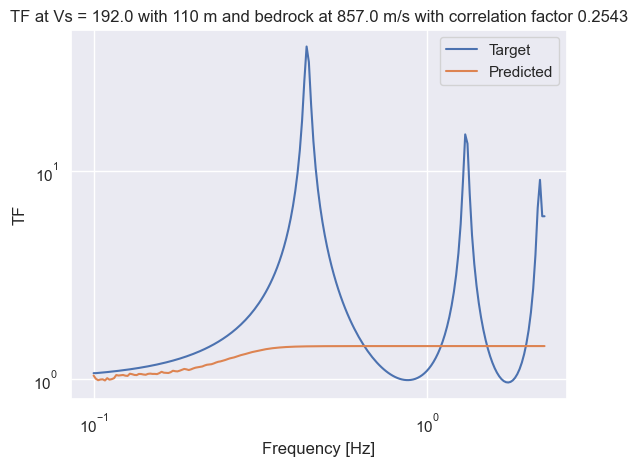

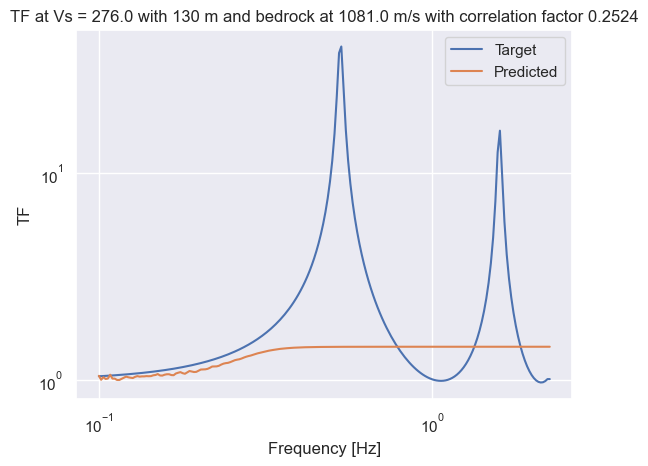

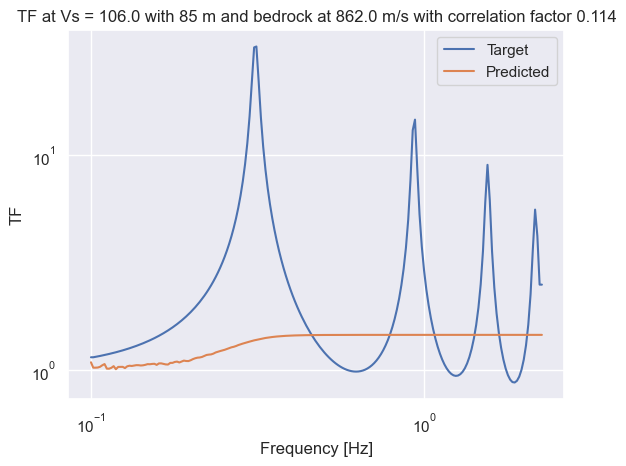

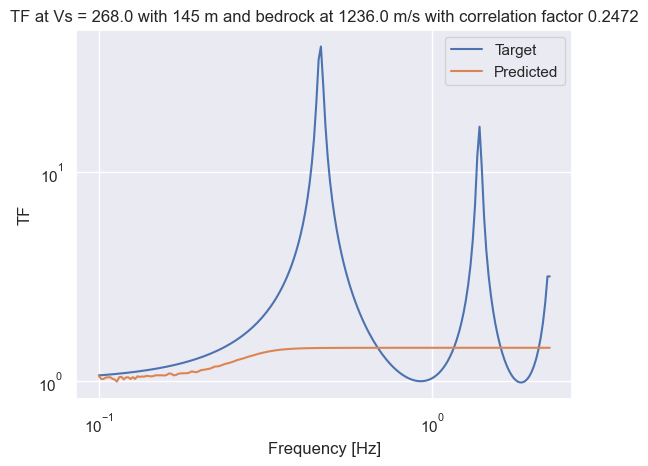

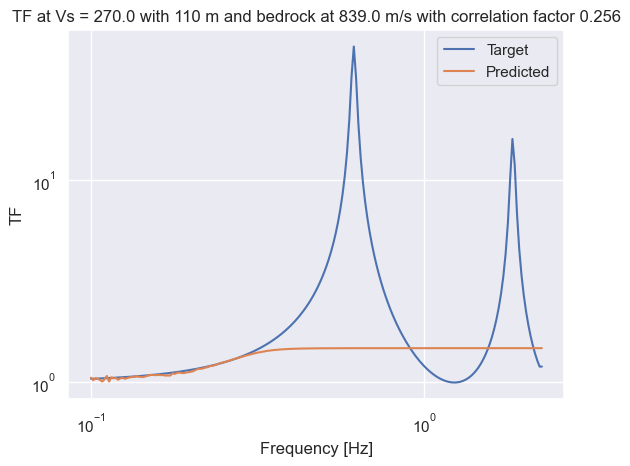

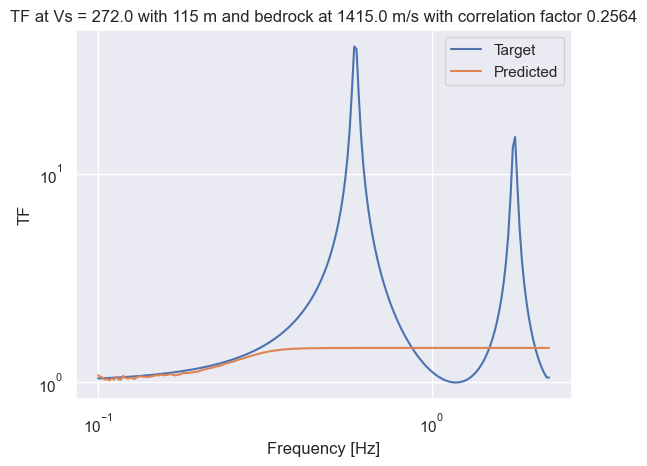

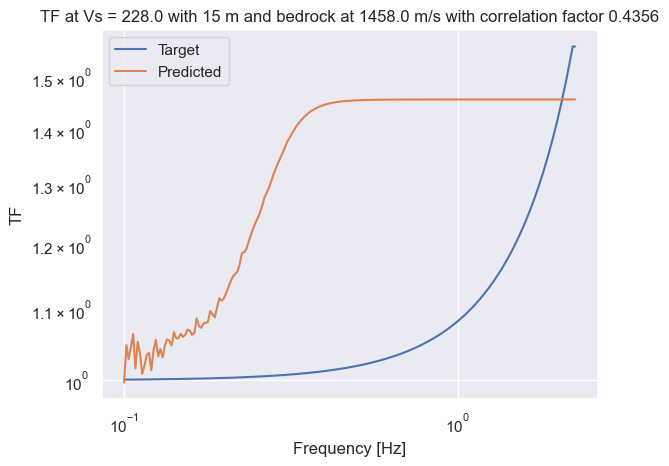

In [236]:
for i in range(target.shape[0]):
    if corr_array[i] < 0.9:
        text_Vs = Vs_data[i,0,:]
        text_Vs = text_Vs[text_Vs != 0]
        plt.loglog(freq_data, target[i,:], label="Target")
        plt.loglog(freq_data, predicted[i,:], label="Predicted")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TF")
        plt.title("TF at Vs = " + str(round(text_Vs[0],0)) + " with " + str(len(text_Vs)*5) + " m and bedrock at " + str(round(text_Vs[-1],0)) 
        + " m/s" + " with correlation factor " + str(round(corr_array[i].item(),4)))
        plt.legend()
        plt.show()
        if i > 5:
            break
    else:
        continue


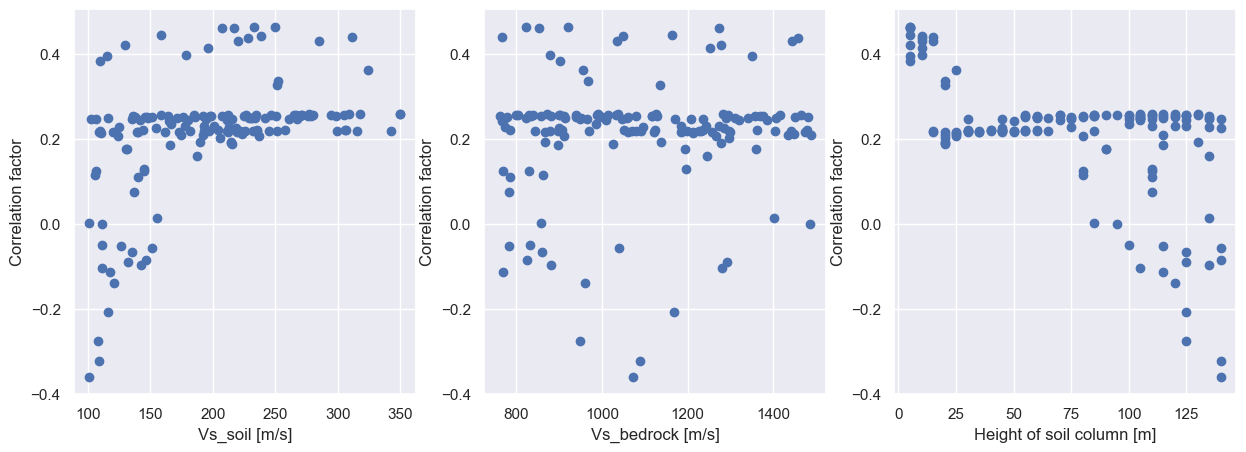

In [239]:
# Plot where x is Vs_soil, Vs_bedrock or height of soil column and y is correlation factor
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(Vs_soil, corr_array)
ax[0].set_xlabel("Vs_soil [m/s]")
ax[0].set_ylabel("Correlation factor")

ax[1].scatter(Vs_bedrock, corr_array)
ax[1].set_xlabel("Vs_bedrock [m/s]")
ax[1].set_ylabel("Correlation factor")

ax[2].scatter(h_soil, corr_array)
ax[2].set_xlabel("Height of soil column [m]")
ax[2].set_ylabel("Correlation factor")

plt.show()